# Brain Tumor Segmentation Attention Unet- CBAM



In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
f="/content/drive/MyDrive/archive.zip"
with ZipFile(f,'r') as z:
  z.extractall()
  print('done')

done


**The process of segmenting tumor from MRI image of a brain is one of the highly focused areas in the community of medical science as MRI is noninvasive imaging. Therefore, I decided to create Brain Tumor Segmentation Notebook  that you can easily use the capabilities of this powerful tool. I am currently in the early stages of designing this Notebook and will be constantly updating these codes to get to a usable version.**

**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import concatenate
from tensorflow.keras.layers import Concatenate, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
! pip install nilearn
from nilearn import plotting
#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'):

    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_236/BraTS20_Training_236_flair.nii
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_236/BraTS20_Training_236_seg.nii
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_236/BraTS20_Training_236_t2.nii
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_236/BraTS20_Training_236_t1.nii
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_236/BraTS20_Training_236_t1ce.nii
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_153/BraTS20_Training_153_t2.nii
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_153/BraTS20_Training_153_t1ce.nii
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_Trainin

# **BraTs2020 Data Visualization**
**In this section, I select a sample data from Brats2020  and visualize it to see the input data**

In [ ]:
#Flair= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_flair.nii')
Flair= nib.load('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_flair.nii')
Seg= nib.load('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii')
T1= nib.load('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1.nii')
T1ce= nib.load('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1ce.nii')
T2= nib.load('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t2.nii')

**Fluid-attenuated inversion recovery (FLAIR) :**

**FLAIR is an MRI sequence with an inversion recovery set to null fluids. For example, it can be used in brain imaging to suppress cerebrospinal fluid (CSF) effects on the image, so as to bring out the periventricular hyperintense lesions, such as multiple sclerosis (MS) plaques**

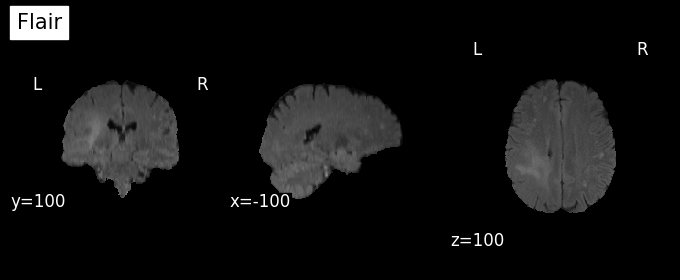

In [ ]:
plotting.plot_anat(Flair,cut_coords=[-100, 100, 100],title="Flair",draw_cross =False)

**Manual segmentation that annotated by an expert**

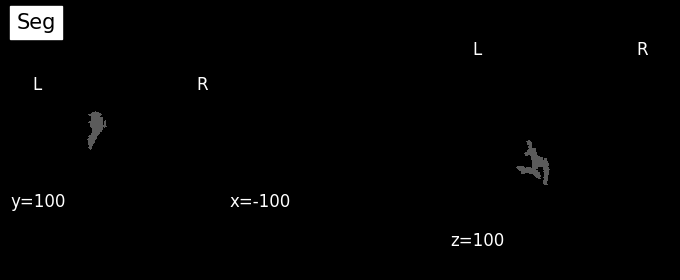

In [ ]:
plotting.plot_anat(Seg,cut_coords=[-100, 100, 100],title="Seg",draw_cross =False)

**T1 weighted images :**

**Magnetic resonance imaging uses the resonance of the protons to generate images. Protons are excited by a radio frequency pulse at an appropriate frequency (Larmor frequency) and then the excess energy is released in the form of a minuscule amount of heat to the surroundings as the spins return to their thermal equilibrium. The magnetization of the proton ensemble goes back to its equilibrium value with an exponential curve characterized by a time constant T1.**

**T1 weighted images can be obtained by setting short repetition time (TR) such as < 750 ms and echo time (TE) such as < 40 ms in conventional spin echo sequences, while in Gradient Echo Sequences they can be obtained by using flip angles of larger than 50o while setting TE values to less than 15 ms.**

**T1 is significantly different between grey matter and white matter and is used when undertaking brain scans. A strong T1 contrast is present between fluid and more solid anatomical structures, making T1 contrast suitable for morphological assessment of the normal or pathological anatomy, e.g., for musculoskeletal applications.**

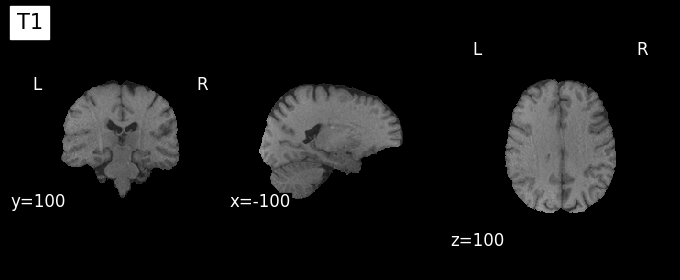

In [ ]:
plotting.plot_anat(T1,cut_coords=[-100, 100, 100],title="T1",draw_cross =False)

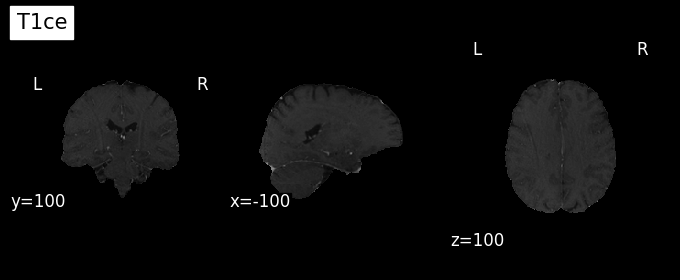

In [ ]:
plotting.plot_anat(T1ce,cut_coords=[-100, 100, 100],title="T1ce",draw_cross =False)

**T2 weighted image :**


**T2 weighted image (T2WI) is one of the basic pulse sequences in MRI. The sequence weighting highlights differences in the T2 relaxation time of tissues.**

**The amount of T2 decay a tissue experiences depends on multiple factors. Each tissue has an inherent T2 value, but external factors (such as magnetic field inhomogeneity) can decrease the T2 relaxation time. This additional effect is captured in T2*. The refocusing pulse in spin-echo sequences helps to mitigate these extraneous influences on the T2 relaxation time, trying to keep the image T2 weighted rather than T2* weighted.**

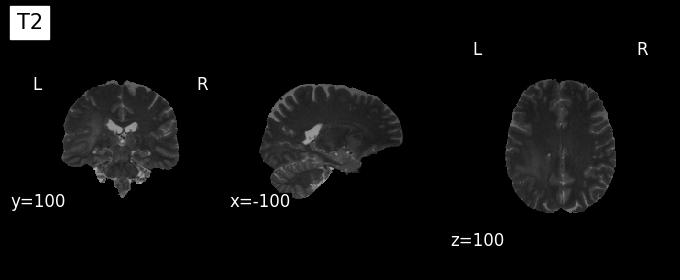

In [ ]:
plotting.plot_anat(T2,cut_coords=[-100, 100, 100],title="T2",draw_cross =False)

# Data Preprocessing

In [ ]:
Path= '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
#Path='D:/BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
p=os.listdir(Path)
Input_Data= []
def Data_Preprocessing(modalities_dir):
    all_modalities = []
    for modality in modalities_dir:
        nifti_file   = nib.load(modality)
        brain_numpy  = np.asarray(nifti_file.dataobj)
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    return all_modalities
for i in p[:20]:
    brain_dir = os.path.normpath(Path+'/'+i)
    flair     = glob.glob(os.path.join(brain_dir, '*_flair*.nii'))
    t1        = glob.glob(os.path.join(brain_dir, '*_t1*.nii'))
    t1ce      = glob.glob(os.path.join(brain_dir, '*_t1ce*.nii'))
    t2        = glob.glob(os.path.join(brain_dir, '*_t2*.nii'))
    gt        = glob.glob( os.path.join(brain_dir, '*_seg*.nii'))
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)


**Check the output**

Text(0.5, 1.0, 'Mask')

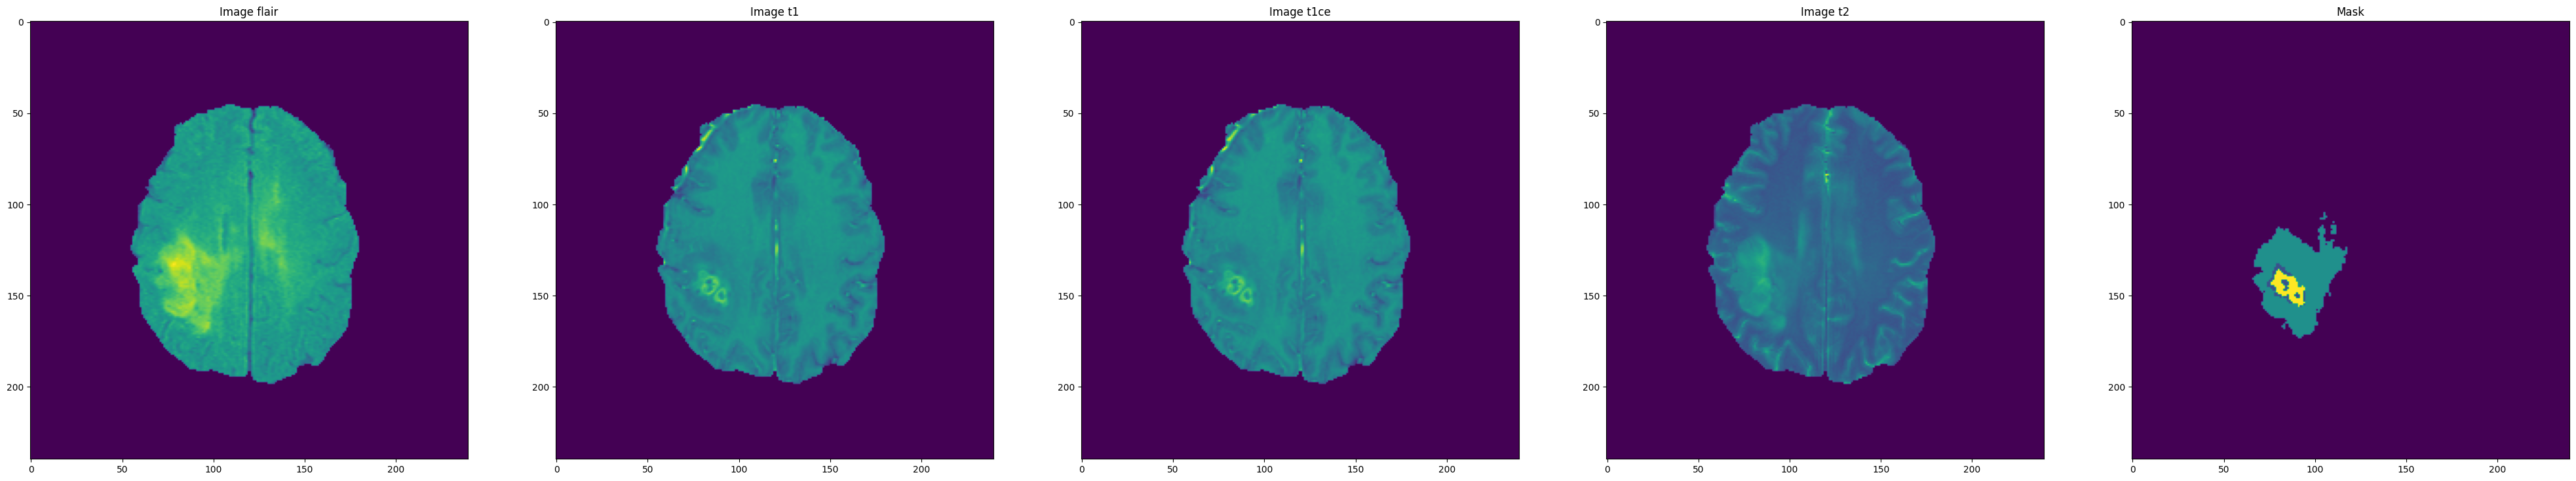

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (50, 20))
ax1.imshow(Input_Data[12][100,:,:,0])
ax1.set_title('Image flair')
ax2.imshow(Input_Data[12][100,:,:,1])
ax2.set_title('Image t1')
ax3.imshow(Input_Data[12][100,:,:,2])
ax3.set_title('Image t1ce')
ax4.imshow(Input_Data[12][100,:,:,3])
ax4.set_title('Image t2')
ax5.imshow(Input_Data[12][100,:,:,4])
ax5.set_title('Mask')

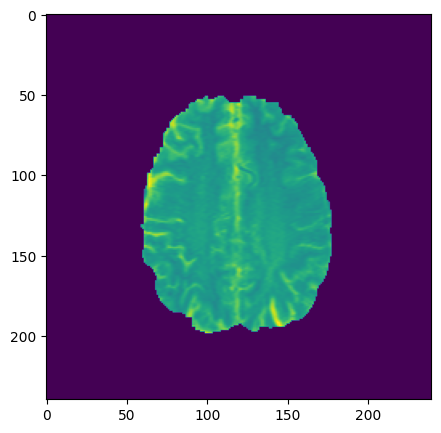

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = Input_Data[15][100,:,:,3]
imgplot = plt.imshow(immmg)
plt.show()

**concatenate images**

In [ ]:
def Data_Concatenate(Input_Data):
    counter=0
    Output= []
    for i in range(5):
        print('$')
        c=0
        counter=0
        for ii in range(len(Input_Data)):
            if (counter != len(Input_Data)):
                a= Input_Data[counter][:,:,:,i]
                print('a={}'.format(a.shape))
                b= Input_Data[counter+1][:,:,:,i]
                print('b={}'.format(b.shape))
                if(counter==0):
                    c= np.concatenate((a, b), axis=0)
                    print('c1={}'.format(c.shape))
                    counter= counter+2
                else:
                    c1= np.concatenate((a, b), axis=0)
                    c= np.concatenate((c, c1), axis=0)
                    print('c2={}'.format(c.shape))
                    counter= counter+2
        c= c[:,:,:,np.newaxis]
        Output.append(c)
    # print ("Printing output: \n")
    # for x in range(len(Output)):
    #   print (Output[x])
    return Output

In [ ]:
InData= Data_Concatenate(Input_Data)

$
a=(155, 240, 240)
b=(155, 240, 240)
c1=(310, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(620, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(930, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(1240, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(1550, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(1860, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(2170, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(2480, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(2790, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(3100, 240, 240)
$
a=(155, 240, 240)
b=(155, 240, 240)
c1=(310, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(620, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(930, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(1240, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(1550, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(1860, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(2170, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(2480, 240,

In [ ]:
AIO= concatenate(InData, axis=3)
#AIO=tf.keras.layers.concatenate(InData, axis=3)
AIO=np.array(AIO,dtype='float32')
TR=np.array(AIO[:,:,:,1],dtype='float32')
TRL=np.array(AIO[:,:,:,4],dtype='float32')

In [ ]:
TR[20].max()

448.0

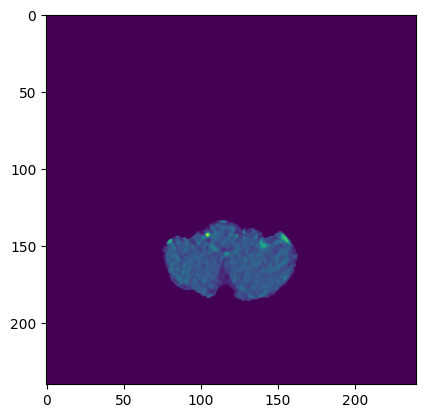

In [ ]:
plt.imshow(TR[20])


In [ ]:
X_train , X_test, Y_train, Y_test = train_test_split(TR, TRL, test_size=0.15, random_state=32)
AIO=TRL=0

**Implement Unet**

**The u-net is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin. architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.**

In [ ]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(2635, 240, 240) (465, 240, 240) (2635, 240, 240) (465, 240, 240)


In [ ]:
import cv2
for i in range(len(Y_test)):#len(Y_test)
  im1=Y_test[i]
  im1=im1/im1.max()
  im2=Y_test[i]
  im2=im2/im2.max()

  im1_bw= cv2.threshold(im1, 0.5, 1, cv2.THRESH_BINARY)[1]
  im2_bw= cv2.threshold(im2, 0.5, 1, cv2.THRESH_BINARY)[1]

  I=cv2.bitwise_and(im1_bw,im2_bw)
  U=cv2.bitwise_or(im1_bw,im2_bw)

  ii=sum(I[np.nonzero(I)])
  uu=sum(U[np.nonzero(U)])

  iou = ii/(uu+0.000001)
  print(iou)





<ipython-input-20-30139c2a8457>:4: RuntimeWarning: invalid value encountered in true_divide
  im1=im1/im1.max()
<ipython-input-20-30139c2a8457>:6: RuntimeWarning: invalid value encountered in true_divide
  im2=im2/im2.max()


0.0
0.9999999973753281
0.0
0.9999999962546817
0.0
0.9999999980988593
0.0
0.0
0.9999999924812031
0.9999999814814818
0.9999999979296066
0.0
0.9999999986052999
0.0
0.9999999984126984
0.0
0.9999999955947136
0.0
0.0
0.9999999970845481
0.0
0.9999999946808511
0.9999999824561407
0.0
0.9999999991356957
0.0
0.999999998509687
0.0
0.9999999964028777
0.0
0.9999999993658846
0.999999997995992
0.0
0.99999950000025
0.0
0.9999999970674487
0.0
0.0
0.0
0.0
0.0
0.9999999830508478
0.999999991935484
0.0
0.0
0.9999999977426637
0.9999999992732558
0.0
0.0
0.0
0.9999999864864867
0.999999993150685
0.0
0.9999999988399072
0.0
0.0
0.0
0.0
0.9999999975186105
0.9999999949748745
0.0
0.0
0.0
0.9999999991909384
0.9999999902912623
0.0
0.9999999995278566
0.9999999985835694
0.0
0.0
0.9999999985875706
0.0
0.0
0.9999999988465975
0.0
0.0
0.0
0.0
0.9999999986928104
0.9999999959349594
0.9999999957805907
0.0
0.999999998509687
0.0
0.9999990000010001
0.9999999818181822
0.0
0.0
0.9999999976303318
0.9999999890109892
0.999999999376947

In [ ]:
sum(iou[np.nonzero(iou)])

IndexError: ignored

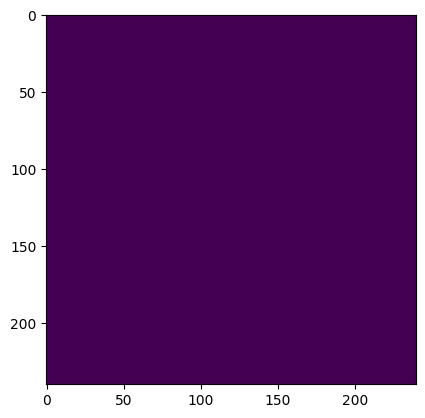

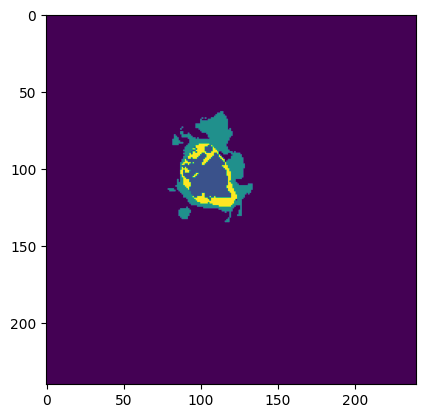

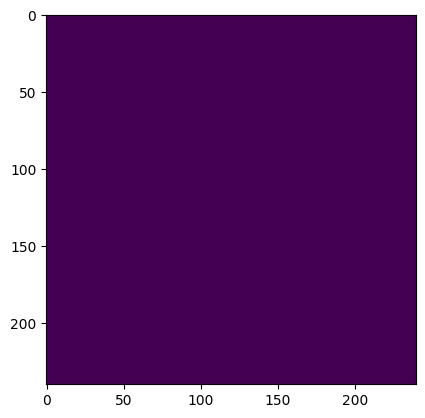

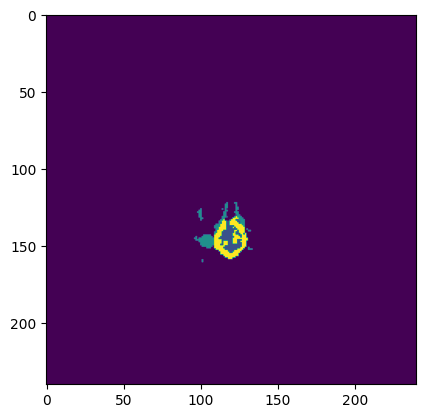

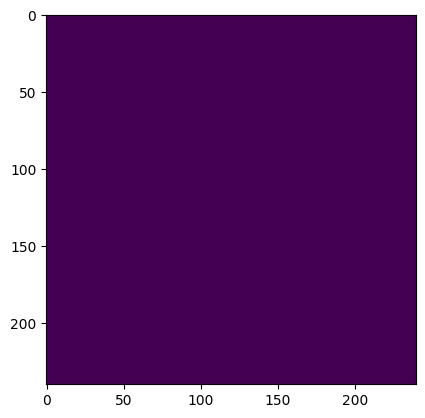

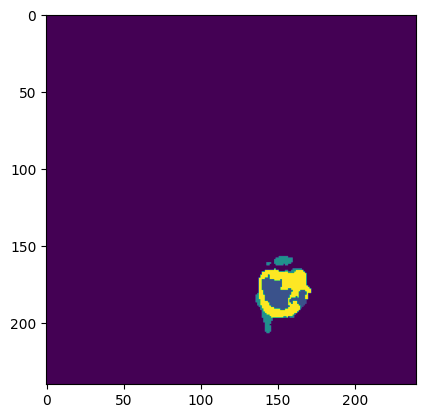

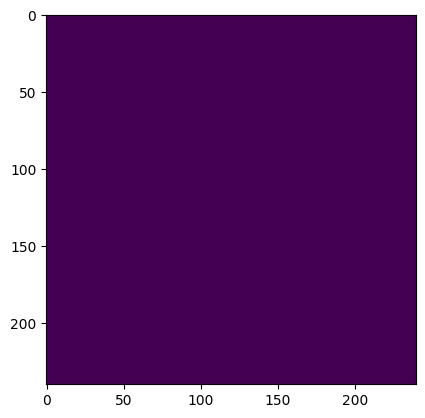

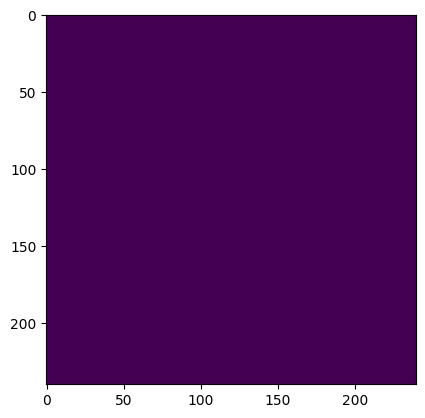

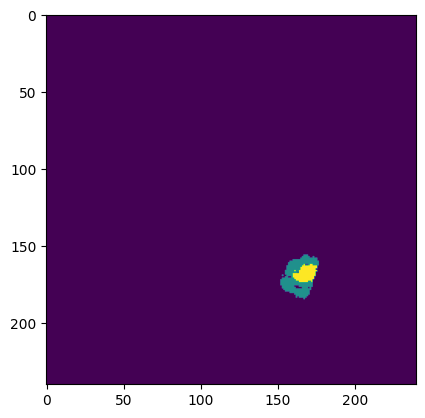

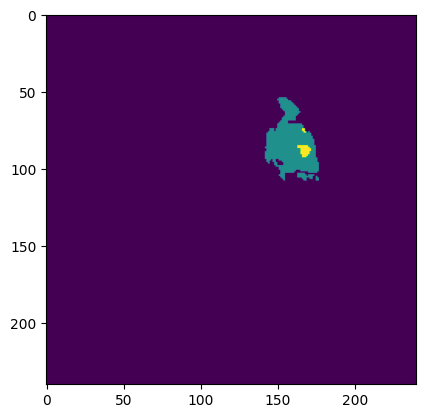

In [ ]:
for i in range(10):
  plt.imshow(Y_test[i])
  plt.show()

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv



def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    UNet,

    '''
    # network structure
    FILTER_NUM = 16 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

# Upsampling layers

    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    ###############################################
    up_16 = cbam_block(up_16)
    ###############################################
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    ###############################################
    up_32 = cbam_block(up_32)
    ###############################################
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8

    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    ###############################################
    up_64 = cbam_block(up_64)
    ###############################################
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    ###############################################
    up_128 = cbam_block(up_128)
    ###############################################
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model
    model = Model(inputs, conv_final, name="UNet")
    return model



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply

"""
Implementation of CBAM: Convolutional Block Attention Module in the TensorFlow 2.5.
Paper: https://arxiv.org/pdf/1807.06521
"""

def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam_block(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x
'''
if __name__ == "__main__":
    inputs = Input(shape=(128, 128, 32))
    y = cbam(inputs)
    print(y.shape)
'''

'\nif __name__ == "__main__":\n    inputs = Input(shape=(128, 128, 32))\n    y = cbam(inputs)\n    print(y.shape)\n'

In [ ]:
# Loding the Light weighted CNN
model = UNet(input_shape = (240,240,1))
# model=cbam(input_shape = (240,240,1))
# inputs= Input(shape=(240, 240, 1))
# model= cbam(inputs)
#print(model.shape)
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 240, 240, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 240, 240, 16  64         ['conv2d_23[0][0]']              
 ormalization)                  )                                                              

In [ ]:
# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# # Computing mIoU
def mean_iou(y_true, y_pred, num_classes=2):
    iou = []
    for i in range(num_classes):
        intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
        union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
        iou.append(intersection / (union+0.000001))
    return tf.reduce_mean(iou)
    # print("Mean IoU:", iou.numpy())



In [ ]:
# Compiling the model
Adam=optimizers.Adam(lr=0.0001)
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity,mean_iou])

In [ ]:
# Fitting the model over the data
history = model.fit(X_train,Y_train,batch_size=32,epochs=50,validation_split=0.30,verbose=1,initial_epoch=0)

Epoch 1/50
58/58 [==============================] - 85s 1s/step - loss: 0.7355 - accuracy: 0.5417 - dice_coef: 0.0552 - precision: 0.0360 - sensitivity: 0.8650 - specificity: 0.5480 - mean_iou: 1.4106e-06 - val_loss: 0.7059 - val_accuracy: 0.0387 - val_dice_coef: 0.0479 - val_precision: 0.0099 - val_sensitivity: 0.9840 - val_specificity: 0.0378 - val_mean_iou: 0.0000e+00
Epoch 2/50
58/58 [==============================] - 29s 493ms/step - loss: 0.6647 - accuracy: 0.8278 - dice_coef: 0.0750 - precision: 0.0593 - sensitivity: 0.9720 - specificity: 0.8351 - mean_iou: 0.0093 - val_loss: 0.7191 - val_accuracy: 0.0357 - val_dice_coef: 0.0499 - val_precision: 0.0099 - val_sensitivity: 0.9868 - val_specificity: 0.0348 - val_mean_iou: 1.9811e-04
Epoch 3/50
58/58 [==============================] - 153s 3s/step - loss: 0.6005 - accuracy: 0.8599 - dice_coef: 0.0788 - precision: 0.0747 - sensitivity: 0.9684 - specificity: 0.8680 - mean_iou: 0.0294 - val_loss: 0.7204 - val_accuracy: 0.7766 - val_dic

In [ ]:

# Evaluating the model on the training and testing data
model.evaluate(x=X_train, y=Y_train, batch_size=32 , verbose=1, sample_weight=None, steps=None)
model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)

In [ ]:
# Accuracy vs Epoch
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

In [ ]:
model.save('./BraTs2020.h5')

In [ ]:
model.load_weights('./BraTs2020.h5')

In [ ]:
pref_Tumor = model.predict(TR)

NameError: ignored

In [ ]:
# import cv2
# for i in range(len(Y_test)):#len(Y_test)
#   im1=Y_test[i]
#   im1=im1/im1.max()
#   im2=Y_test[i]
#   im2=im2/im2.max()

#   im1_bw= cv2.threshold(im1, 0.5, 1, cv2.THRESH_BINARY)[1]
#   im2_bw= cv2.threshold(im2, 0.5, 1, cv2.THRESH_BINARY)[1]

#   I=cv2.bitwise_and(im1_bw,im2_bw)
#   U=cv2.bitwise_or(im1_bw,im2_bw)

#   ii=sum(I[np.nonzero(I)])
#   uu=sum(U[np.nonzero(U)])

#   iou = ii/(uu+0.000001)
#   print(iou)

# Computing mIoU
# def mean_iou(y_true, y_pred, num_classes=1):
#     iou = []
#     for i in range(num_classes):
#         intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
#         union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
#         iou.append(intersection / (union+0.000001))
#     return tf.reduce_mean(iou)
#     print("Mean IoU:", iou.numpy())

# iou = mean_iou(y_true, y_pred, num_classes=1)
# print("Mean IoU:", iou.numpy())



IoU_values=[]
for img in range (len(Y_test)):

  temp_img=y_pred[img]
  ground_truth=y_true[img]

  gt=ground_truth.squeeze()>0
  temp_img_input=np.expand_dims(temp_img,0)

  prediction= (model.predict(temp_img_input)[0,:,:,0]>0.5).astype(np.uint8)

  IoU=MeanIoU(num_classes=2)
  IoU.update_state(ground_truth[:,:,0],prediction)
  IoU=IoU.result().numpy()
  IoU_values.append(IoU)

for i in range(len(IoU_values)):
  print (IoU_values[i])

NameError: ignored

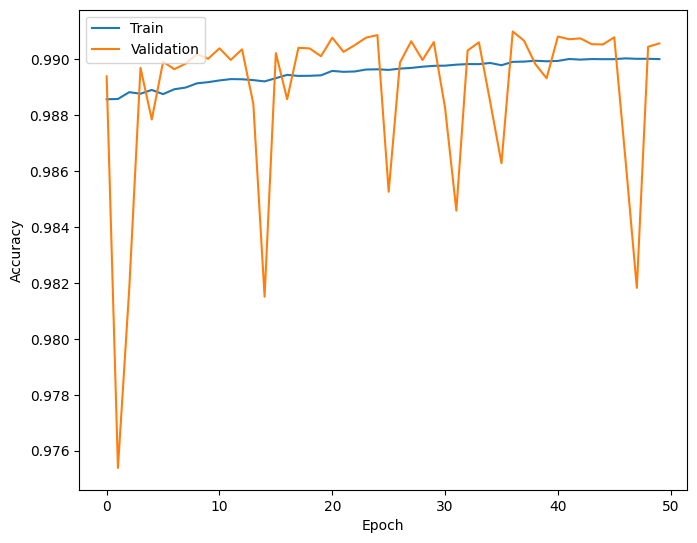

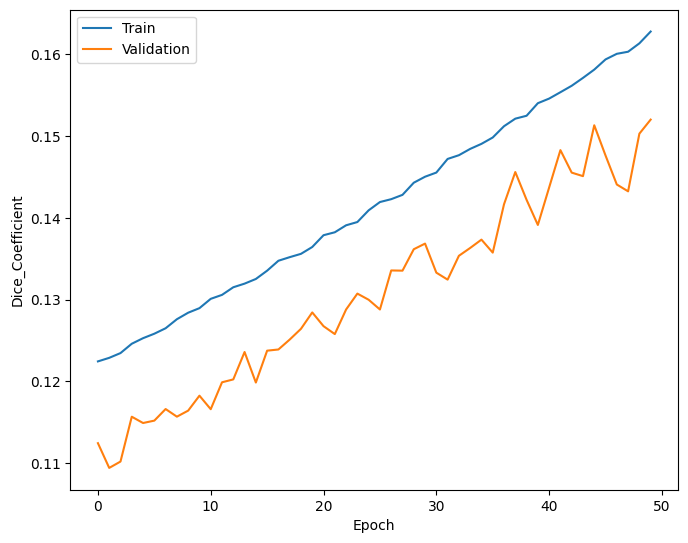

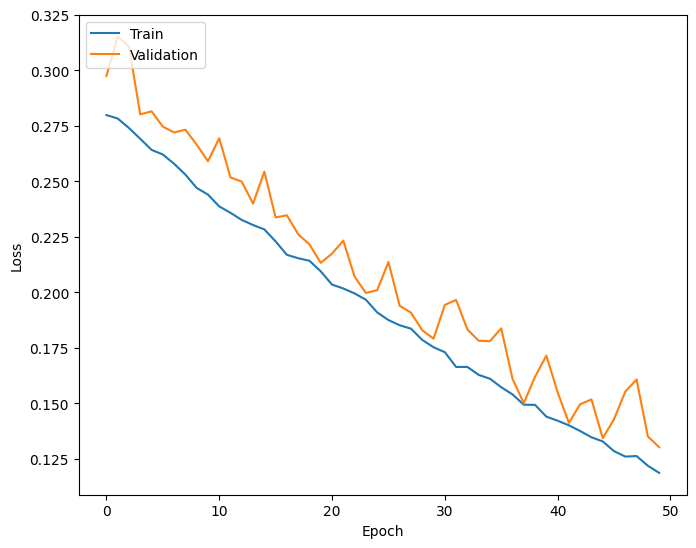

In [ ]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)

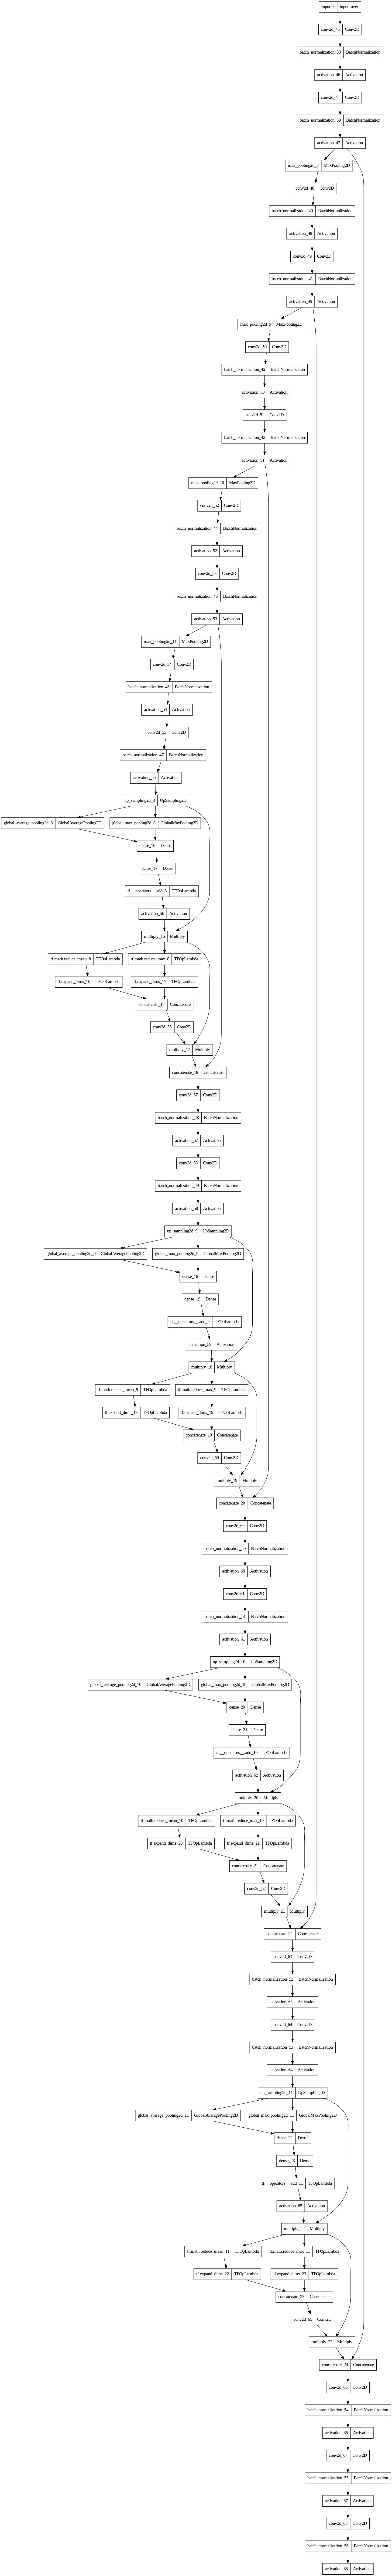

In [ ]:
from keras.utils import plot_model
plot_model(model,to_file='model.png')

In [ ]:
X_train=X_test=Y_train=Y_test=0

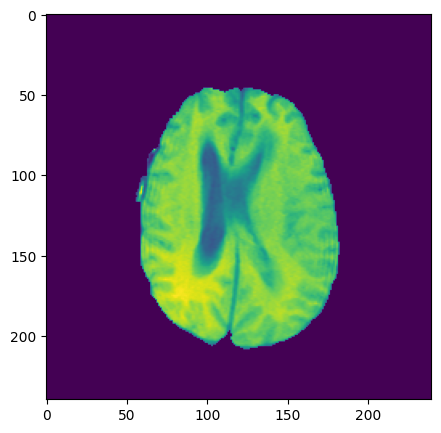

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = TR[250,:,:]
imgplot = plt.imshow(immmg)
plt.show()

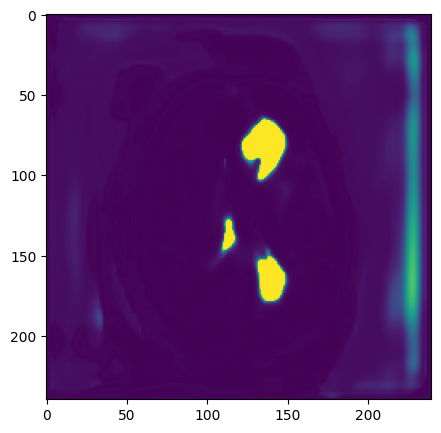

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = pref_Tumor[250,:,:,0]
imgplot = plt.imshow(immmg)
plt.show()

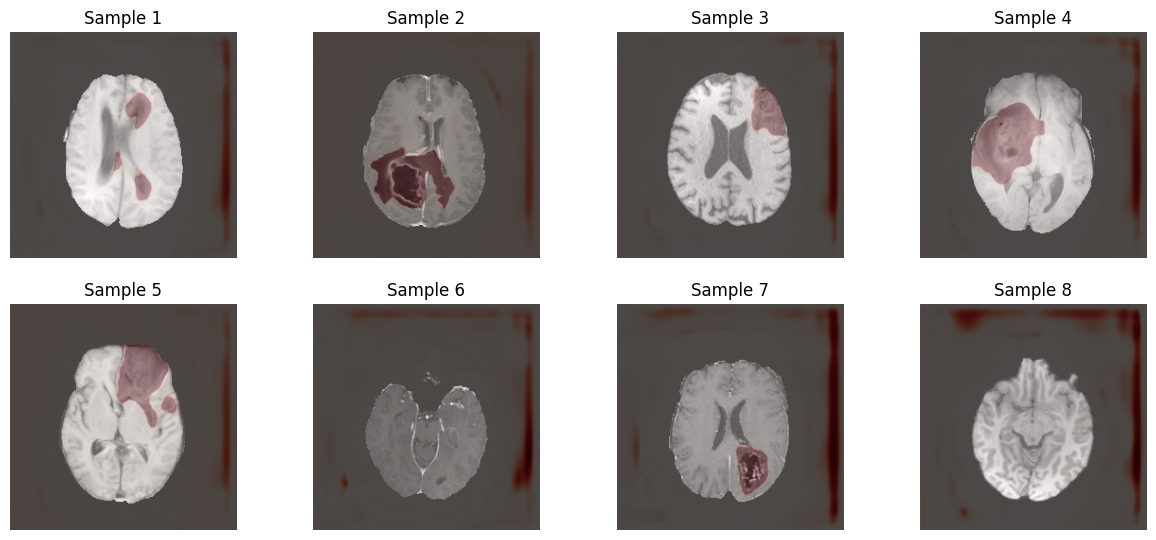

In [ ]:
plt.figure(figsize=(15,10))


plt.subplot(341)
plt.title('Sample 1')
plt.axis('off')
plt.imshow(np.squeeze(TR[250,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[250,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(342)
plt.title('Sample 2')
plt.axis('off')
plt.imshow(np.squeeze(TR[550,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[550,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(343)
plt.title('Sample 3')
plt.axis('off')
plt.imshow(np.squeeze(TR[400,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[400,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(344)
plt.title('Sample 4')
plt.axis('off')
plt.imshow(np.squeeze(TR[690,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[690,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(345)
plt.title('Sample 5')
plt.axis('off')
plt.imshow(np.squeeze(TR[850,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[850,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(346)
plt.title('Sample 6')
plt.axis('off')
plt.imshow(np.squeeze(TR[1450,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[1450,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(347)
plt.title('Sample 7')
plt.axis('off')
plt.imshow(np.squeeze(TR[1800,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[1800,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(348)
plt.title('Sample 8')
plt.axis('off')
plt.imshow(np.squeeze(TR[60,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[60,:,:]),alpha=0.3,cmap='Reds')

In [ ]:
from sklearn.metrics import f1_score
from tensorflow.keras.metrics import MeanIoU

test_img_number = random.randint(0, len(im_test))
test_img = im_test[test_img_number]
ground_truth=gt_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())
